# Coursework 1
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín 

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [ ]:
### Set 'install = true' if using for the first time ###
install = false
if install
    packages = ["Plots", "LaTeXStrings", "PrettyTables", "LinearAlgebra", "Printf"]
    using Pkg
    Pkg.add.(packages)
end

In [ ]:
using Plots
using LaTeXStrings
using PrettyTables
using LinearAlgebra
using Printf

In [3]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: Plots

### a) Producing a plot of the sinc function

$$
    h(x) = \begin{cases}
    \frac{1}{x}\sin(x) & x\neq 0 \\
    1 & x = 0
    \end{cases}
$$

Using $n=100$ equally spaced points for $x\in[0, 2\pi]$. We display $h(x)$ with a dotted magenta line

In [4]:
function h(x)
    """
    Defining the sinc function
    """
    if x != 0
        return sin(x) / x
    else
        return 1
    end
end

h (generic function with 1 method)

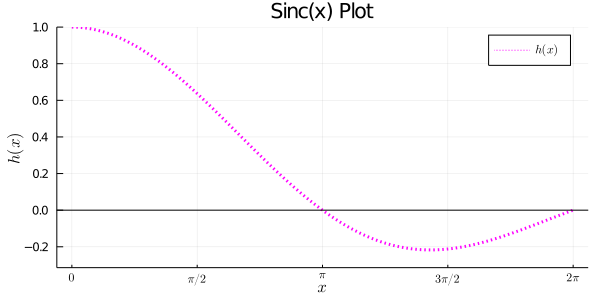

In [5]:
xvals = range(0, 2π, length=100)
xticks_labs = [L"0", L"\pi/2", L"\pi", L"3\pi/2", L"2\pi"]
xticks_vals = 0:π/2:2π

plot(xvals, h.(xvals), title="Sinc(x) Plot", label=L"h(x)",
    lw=3, c="magenta", linestyle=:dot,
    xticks=(xticks_vals, xticks_labs),
    ylim=(-0.314,1))
plot!([0], seriestype=:hline, c="black", label=nothing)
xlabel!(L"x")
ylabel!(L"h(x)")

### b) Plot of two functions (I)

Produce a plot of the two functions

$$
    f(y) = y(2 y^2 - 5)(y^2 - 1)^{1/2} + 3 \log\left(y + (y^2 - 1)^{1/2}\right)
$$

$$
    g(y) = y (2 y ^ 2 - 1) (y^2 - 1)^{1/2} - \log(y + (y^2 - 1)^{1/2})
$$

for $y \in [1, 2]$. We will display $f(y)$ with red dashes and $g(y)$ with solid blue line

In [6]:
function f(y)
    term = sqrt(y ^ 2 - 1)
    fval = y * (2 * y ^ 2 - 5) * term + 3 * log(y + term)
    return fval
end

function g(y)
    term = sqrt(y^2 - 1)
    gval = y * (2 * y ^ 2 - 1) * term - log(y + term)
    return gval
end

g (generic function with 1 method)

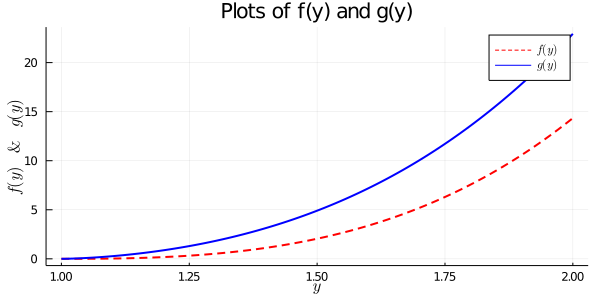

In [7]:
xvals = range(1, 2, length=100)
f_vals = f.(xvals)
g_vals = g.(xvals)

plot(xvals, f_vals, label=L"f(y)", c="red", style=:dash, lw=2)
plot!(xvals, g_vals, label=L"g(y)", c="blue", style=:solid, lw=2)
xlabel!(L"y")
ylabel!(L"f(y)\quad &\quad g(y)")
title!("Plots of f(y) and g(y)")

### c) log-log plot of two functions

Produce a parametric log-log plot of $s=f(y)$ as a function of $t=g(y)$, with $g(y)$ defined in `b)`, for $y\in[1, 2]$. Display the points $(t,s) = (g(y), f(y))$ in magenta.

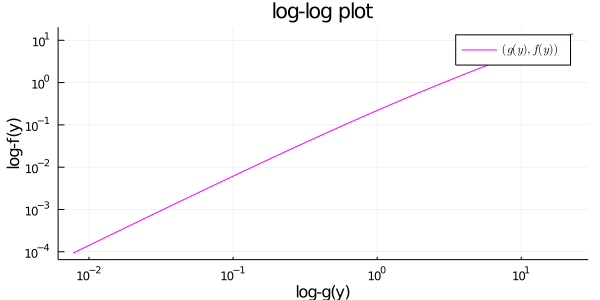

In [8]:
plot(g_vals[2:end], f_vals[2:end], xaxis=:log10, yaxis=:log10,
    c="magenta", title="log-log plot", label=L"(g(y), f(y))",
    xlabel="log-g(y)", ylabel="log-f(y)")

### d) Plot of two functions (II)

Produce a plot of the two functions

$$
\begin{aligned}
    u(t) &= \cos(t)\\
    v(t) &= t
\end{aligned}
$$

For $t \in [0,1]$. Display $u(t)$ with a red solid line and $v(t)$ with green crosses

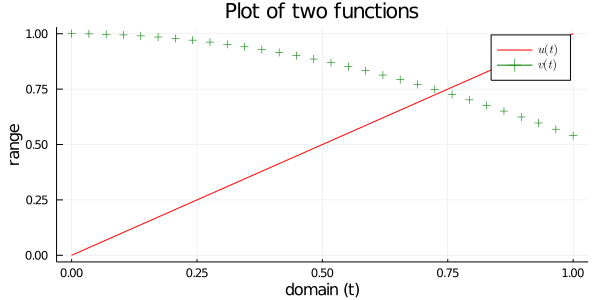

In [9]:
tvals = range(0, 1, length=30)
plot(tvals, tvals, c="red", label=L"u(t)",
    xlabel="domain (t)", ylabel="range", title="Plot of two functions")
plot!(tvals, cos.(tvals), c="green", marker=:cross, lw=0, label=L"v(t)")

## Question 2: Fixed point iteration

In this exercise we will make use of a `while` loop to find the value of $x_\infty$ that satisfies

$$
    \cos x_\infty = x_\infty
$$

Up to a tolerance $\epsilon$ of $10^{-16}$.

In [10]:
# starting_values
x_old, eps = 1., Inf

while eps > 10e-16
    x_new = cos(x_old)
    eps = abs(x_new - x_old)
    x_old = x_new
end

round(x_old, digits=16)

0.7390851332151603

In [11]:
abs(x_old - cos(x_old))

4.440892098500626e-16

## Question 3: Lane-Emden equation

The Lane-Emden equation is given by
$$
\begin{align*}
    h''(x) + \frac{2}{x} h'(x) + h(x) &= 0\\
    h(0) &= 1\\
    h'(0) &= 0\\
\end{align*}
$$

We can rewrite the Lane-Embed equation as a system of two first-order ODEs given by

$$
\begin{align*}
z'(x) &= -\frac{1}{3}\mathbb{1}(x = 0) - \left(\frac{2}{x}z(x) + h(x)\right)\mathbb{1}(x > 0)\\
h'(x) &= z(x)
\end{align*}
$$

With initial conditions $h(0)= 1$, $z(0) = 0$

$$
    \dot{\bf u} = f(t, {\bf u})
$$

### The Runge-Kutta algorithm

In this section we will solve the Lane-Embden equation using a 4-th order Runge-Kutta method

**Inputs**: $a$, $b$, $N$ with initial conditions $\boldsymbol\alpha$, $f(t,{\bf u})$

#### Step 1
Set
* $h = (b - a) / N$
* ${\bf u} := \boldsymbol\alpha$
* `Store` $(t,{\bf u})$

#### Step 2
For $n=1,\ldots,N$

* $\forall i. \quad k_{1,i} = h\cdot f_i(t, u_1, \ldots, u_M)$
* $\forall i. \quad k_{2,i} = h\cdot f_i(t + \frac{h}{2}, u_1 + \frac{k_{1, 1}}{2}, \ldots, u_M  + \frac{k_{1, M}}{2})$
* $\forall i. \quad k_{3,i} = h\cdot f_i(t + \frac{h}{2}, u_1 + \frac{k_{2, 1}}{2}, \ldots, u_M  + \frac{k_{2, M}}{2})$
* $\forall i. \quad k_{4,i} = h\cdot f_i(t + \frac{h}{2}, u_1 + \frac{k_{3, 1}}{2}, \ldots, u_M  + \frac{k_{3, M}}{2})$
* $\forall i. \quad u_i := u_i + (k_{1,i} + 2k_{2,i} + 2k_{3,i} + k_{4,i}) / 6$


* Let $t = a + n \cdot h$
* `Store` $(t, {\bf u})$

In [12]:
function lane_embden(t, zt, ht)
    """
    Evaluate the change in the Lane-Emben equation
    at t with observed values zt := z(t) & ht := h(t)
    
    Returns
    -------
    fz, fh: the values of the system
    """
    fz = t == 0 ? -1/3 : -(2/t * zt + ht)
    fh = zt
    
    return fz, fh
end

function rk4_lane_embden(b, N)
    """
    Integrate the Lane Embden equation
    from 0 to b using a 4th-order Runge-Kutta method
    with conditions h(0) = 1 and z(0) = 0
    """
    a = 0
    t = a
    hv = (b - a) / N
    tvals = a:hv:b + hv
    tvals = length(tvals) == N + 1 ? tvals : tvals[begin:end-1]
    hvals = zeros(N + 1)
    zvals = zeros(N + 1)
    
    zt, ht = 0, 1
    zvals[1] = zt
    hvals[1] = ht
    
    for n=1:N
        k1z, k1h = hv .* lane_embden(t, zt, ht)
        k2z, k2h = hv .* lane_embden(t + hv/2, zt + k1z / 2, ht + k1h / 2)
        k3z, k3h = hv .* lane_embden(t + hv/2, zt + k2z / 2, ht + k2h / 2)
        k4z, k4h = hv .* lane_embden(t + hv, zt + k3z, ht + k3h)
        # Value updates
        zt = zt + (k1z + 2k2z + 2k3z + k4z) / 6
        ht = ht + (k1h + 2k2h + 2k3h + k4h) / 6

        zvals[n + 1] = zt
        hvals[n + 1] = ht

        t = a + n * hv
    end
    
    return tvals, zvals, hvals
end

rk4_lane_embden (generic function with 1 method)

In [13]:
N = 100
a, b = 0, 10pi

hv = (b - a) / N
tvals = a:hv:b + hv
tvals = length(tvals) == N + 1 ? tvals : tvals[begin:end-1]
hvals = zeros(N + 1)
zvals = zeros(N + 1);

In [14]:
t = a
zt, ht = 0, 1

zvals[1] = zt
hvals[1] = ht

for n=1:N
    k1z, k1h = hv .* lane_embden(t, zt, ht)
    k2z, k2h = hv .* lane_embden(t + hv/2, zt + k1z / 2, ht + k1h / 2)
    k3z, k3h = hv .* lane_embden(t + hv/2, zt + k2z / 2, ht + k2h / 2)
    k4z, k4h = hv .* lane_embden(t + hv, zt + k3z, ht + k3h)
    # Value updates
    zt = zt + (k1z + 2k2z + 2k3z + k4z) / 6
    ht = ht + (k1h + 2k2h + 2k3h + k4h) / 6
    
    zvals[n + 1] = zt
    hvals[n + 1] = ht
    
    t = a + n * hv
end

In [15]:
N = 100
a, b = 0, pi
tvals, zvals, hvals = rk4_lane_embden(b, N);

In [16]:
function formatters(v, i, j)
    vi = j == 1 ? Int(v) : round(v, digits=3)
    return vi
end

data = [1:10:(N+1) tvals[begin:10:end] hvals[begin:10:end]]
pretty_table(data, ["i", "xi", "h(xi)"], formatters=formatters)

┌─────┬───────┬───────┐
│   i │    xi │ h(xi) │
├─────┼───────┼───────┤
│   1 │   0.0 │   1.0 │
│  11 │ 0.314 │ 0.984 │
│  21 │ 0.628 │ 0.935 │
│  31 │ 0.942 │ 0.858 │
│  41 │ 1.257 │ 0.757 │
│  51 │ 1.571 │ 0.637 │
│  61 │ 1.885 │ 0.505 │
│  71 │ 2.199 │ 0.368 │
│  81 │ 2.513 │ 0.234 │
│  91 │ 2.827 │ 0.109 │
│ 101 │ 3.142 │  -0.0 │
└─────┴───────┴───────┘


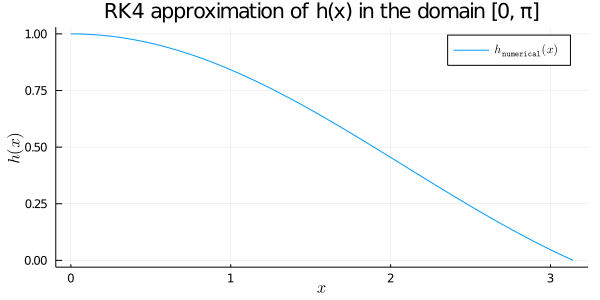

In [17]:
plot(tvals, hvals, label=L"h_\texttt{numerical}(x)",
    title="RK4 approximation of h(x) in the domain [0, π]",
    ylabel=L"h(x)", xlabel=L"x")

### Differences

In this part we will compute the differences $e(x)$ between our numerical solution and the exact solution, i.e.,

$$
    e(x) := h_\text{numerical}(x) - h_\text{exact}(x)
$$

Where $h_\text{exact}(x) = \text{sinc}(x)$

In [18]:
differences = hvals - h.(tvals);

In [19]:
function formatters(v, i, j)
    if j == 1
        vi = Int(v)
    elseif j == 2
        vi = round(v, digits=3)
    else
        vi = @sprintf("%.2E", v)
    end
        
    return vi
end

data = [0:10:N tvals[begin:10:end] differences[begin:10:end]]
pretty_table(data, ["i", "xi", "e(xi)"], formatters=formatters)

┌─────┬───────┬───────────┐
│   i │    xi │     e(xi) │
├─────┼───────┼───────────┤
│   0 │   0.0 │  0.00E+00 │
│  10 │ 0.314 │ -1.41E-09 │
│  20 │ 0.628 │ -1.98E-09 │
│  30 │ 0.942 │ -2.11E-09 │
│  40 │ 1.257 │ -2.13E-09 │
│  50 │ 1.571 │ -2.11E-09 │
│  60 │ 1.885 │ -2.11E-09 │
│  70 │ 2.199 │ -2.15E-09 │
│  80 │ 2.513 │ -2.27E-09 │
│  90 │ 2.827 │ -2.46E-09 │
│ 100 │ 3.142 │ -2.71E-09 │
└─────┴───────┴───────────┘


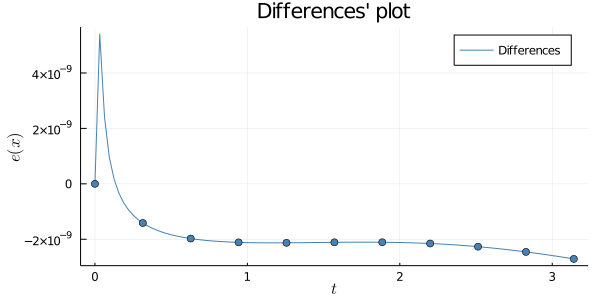

In [20]:
plot(tvals, differences, label="Differences", xlabel=L"t", ylabel=L"e(x)",
     title="Differences' plot", color=:steelblue)
plot!(tvals[begin:10:end], differences[begin:10:end],
    linewidth=0, marker=true, label=nothing, color=:steelblue)

### Error norms

In this part we will compute the $\ell_1$ and $\ell_2$ error norms given by

$$
    \ell_1 = \sum_{n=1}^N \vert e_i\vert
$$

$$
    \ell_2 = \sqrt{\sum_{n=1}^N \vert e_i\vert^2}
$$

In [21]:
# Computing the error norms
l1 = sum(abs.(differences))
l2 = sqrt(sum(differences .^ 2));

println("l1 error norm: $(@sprintf("%.5E", l1))")
println("l2 error norm: $(@sprintf("%.5E", l2))")

l1 error norm: 2.09764E-07
l2 error norm: 2.16607E-08


### The stellar radius

In this part we determine the stellar radius, that is, the value $x=R$ where our numerical solution first vanishes, i.e., $h_\texttt{approx}(R) = 0$.

In [22]:
tvals, zvals, hvals = rk4_lane_embden(3.2, 103);

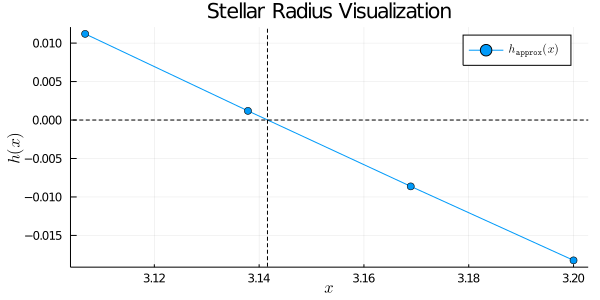

In [23]:
plot(tvals[end-3:end], hvals[end-3:end], marker=true, label=L"h_\texttt{approx}(x)",
     xlabel=L"x", ylabel=L"h(x)", title="Stellar Radius Visualization")
hline!([0], color="black", linestyle=:dash, linewidth=1, label=nothing)
vline!([pi], color="black", linestyle=:dash, linewidth=1, label=nothing)

To determine the position of the stellar radius, we will consider a 4-point Hermite interpolation. This means that we need to find the 8 coefficients of the polynomial

$$
\begin{align*}
    P(x) &= \sum_{m=1}^7 c_m x^m\\
         &= c_0 + c_1 x^1 + c_2 x^2 + c_3 x^3 + c_4 x^4 + c_5 x^5 + c_6 x^6 + c_7 x^7
\end{align*}
$$

That satisfy

$$
    \forall i\in\{1, \ldots, 4\}. \sum_{m=0}^7 c_m x_{i}^m = f_i \label{eq:fi}\tag{1}\\
$$

$$
    \forall i\in\{1, \ldots, 4\}. \sum_{m=1}^7 m \cdot c_m x_{i}^{m-1} = f'_i \label{eq:fi_p}\tag{2}\\
$$

For the observed values $\{x_1, x_2, x_3, x_4\}$

To determine $\{c_m\}_{m=0}^7$ that satisfy equations $\eqref{eq:fi}$ and $\eqref{eq:fi_p}$, we will create an $8\times 8$ matrix `A`. The first four rows of the matrix `A` will be given by each $x_i$ evaluated at $P$, and the next four rows will be given by each $x_i$ evaluated at $\frac{d}{dx}P(x)$

In [24]:
t_neigh = tvals[end-3:end]
h_neigh = hvals[end-3:end]
z_neigh = zvals[end-3:end]
mvals = 0:7;

In [25]:
A = [t_neigh[:, new] .^ mvals[new, :] ; mvals[new, :] .* t_neigh[:, new] .^ (mvals[new, :] .- 1)]

8×8 Array{Float64,2}:
 1.0  3.1068    9.65218  29.9874   93.1646  289.443   899.242  2793.76
 1.0  3.13786   9.84619  30.896    96.9475  304.208   954.563  2995.29
 1.0  3.16893  10.0421   31.8228  100.844   319.569  1012.69   3209.15
 1.0  3.2      10.24     32.768   104.858   335.544  1073.74   3435.97
 0.0  1.0       6.21359  28.9565  119.949   465.823  1736.66   6294.69
 0.0  1.0       6.27573  29.5386  123.584   484.737  1825.25   6681.94
 0.0  1.0       6.33786  30.1264  127.291   504.222  1917.41   7088.85
 0.0  1.0       6.4      30.72    131.072   524.288  2013.27   7516.19

Next, we will define a vector `b` that contains the values $\{f_1, f_2, f_3, f_4, f'_1,, f'_2, f'_3, f'_4\}$

In [26]:
b = [h_neigh; z_neigh][:, new]

8×1 Array{Float64,2}:
  0.01119787276479292
  0.0011882475056859479
 -0.008626246177332876
 -0.018241922461119393
 -0.32528447320044424
 -0.31906458513178876
 -0.31272367085967956
 -0.30626651785196757

Solving the system of equations yields

In [27]:
c_coef = A\b
round.(c_coef, digits=3)

8×1 Array{Float64,2}:
  -869.817
  1933.243
 -1839.499
   972.193
  -308.301
    58.663
    -6.201
     0.281

Next, we plot our discrete approximation of $h$ and our hermite interpolation

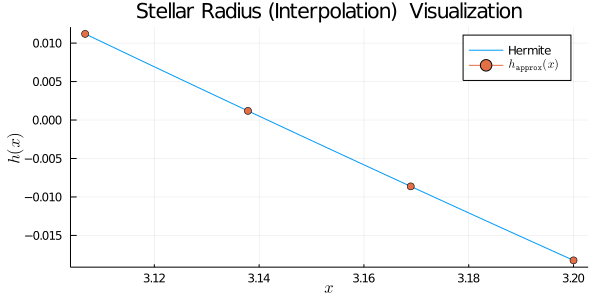

In [28]:
xtest = t_neigh[begin]:0.001:t_neigh[end]

h_test = (xtest[:, new] .^ mvals[new, :]) * c_coef

plot(xtest, h_test, label="Hermite ")
plot!(tvals[end-3:end], hvals[end-3:end], marker=true, label=L"h_\texttt{approx}(x)",
     xlabel=L"x", ylabel=L"h(x)", title="Stellar Radius (Interpolation)  Visualization", linewidth=0)

Finally, we will make use of the bisection method to find the value $x$ such that $h_\text{hermite}(x) = 0$. To make use of the bisection function, we need to find $a$, $b$ such that $\text{sign}(h(a)) \neq \text{sign}(h(b))$, which we choose to be our first and last value of the four points that we chose to perform the hermite interpolation.

In [29]:
function bisection(f, a, b; tol=1e-10)
    """
    Implement the bisection method to find the root
    of a function, i.e., find x such that f(x) = 0.
    To do so, the function requires a, b in R such that
    (f(a) > 0 and f(b) < 0) or ((f(a) < 0 and f(b) > 0))
    """
    c = (a + b) / 2
    err = Inf
    
    while err > tol
        c = (a + b) / 2
        fc = f(c)
        
        if sign(fc) == sign(f(a))
            a = c
        else
            b = c
        end
        
        err = abs(fc)
    end
    return c
end

bisection (generic function with 1 method)

In [30]:
lower, upper = t_neigh[begin], t_neigh[end]
R = bisection(x -> dot(x .^ mvals[new, :],  c_coef), lower, upper, tol=1e-12)

3.141592645455261

We note that our approximation is accurate to 10 decimal places.

In [31]:
R - pi

-8.134532158976526e-9

## Question 4: Fixed point iterator

In this exercsie we will work with the function

$$
    h(x) = 1 + \int_0^x\left(\frac{y^2}{x} - y\right) h(y) dy
$$

### a) Equivalent equations

First, we will show that $h(x)$ satisfies the following three properties

$$
\begin{align}
    h''(x) + \frac{2}{x} h'(x) + h(x) &= 0 \label{eq:id1}\tag{1}\\
    h(0) &= 1 \label{eq:id2}\tag{2}\\
    h'(0) &= 0 \label{eq:id3}\tag{3}\\
\end{align}
$$

----

Let us consider the first and second derivatives of $h$ with respect to $x$. We begin by noting that $h(x)$ can be written in the form

$$
\begin{aligned}
h(x) &= 1 + \int_0^x \frac{y^2}{x} h(y) dy - \int_0^x y h(y) dy\\
     &= 1 + \frac{1}{x}\int_0^x y^2 h(y) dy - \int_0^x y h(y) dy\\
\end{aligned}
$$

Next, we make use of the Leibniz rule to obtain

$$
\begin{align*}
\frac{d}{dx}h(x) &= \frac{d}{dx}\left[1 + \frac{1}{x}\int_0^x y^2 h(y) dy - \int_0^x y h(y) dy\right] \\
&= \frac{d}{dx}\left[\frac{1}{x}\int_0^x y^2 h(y) dy\right] + \frac{d}{dx}\left[- \int_0^x y h(y) dy\right] \\
&= \frac{1}{x}\cdot\frac{d}{dx}\left[\int_0^x y^2 h(y) dy\right] + \frac{d}{dx}\left[\frac{1}{x}\right]\cdot\int_0^x y^2 h(y) dy + \frac{d}{dx}\left[- \int_0^x y h(y) dy\right] \\
&= \frac{1}{x}[x^2 h(x)] - \frac{1}{x^2}\int_0^x y^2 h(y) dy - x h(x) \\
&= x h(x) - \frac{1}{x^2}\int_0^x y^2 h(y) dy - x h(x) \\
&= - \frac{1}{x^2}\int_0^x y^2 h(y) dy \label{eq:h1x}\tag{4}\\
\end{align*}
$$

Furthermore, a second derivative of $h$ with respect to $x$ yields

$$
\begin{align*}
h''(x) &= \frac{d}{dx}\left[h'(x)\right] \\
&= \frac{d}{dx}\left[ - \frac{1}{x^2}\int_0^x y^2 h(y) dy\right] \\
&= -\frac{d}{dx}\left[\frac{1}{x^2}\int_0^x y^2 h(y) dy\right] \\
&= -\frac{d}{dx}\left[\frac{1}{x^2}\right]\int_0^x y^2 h(y) dy - \frac{1}{x^2}\frac{d}{dx}\left[\int_0^x y^2 h(y) dy\right] \\
&=  \frac{2}{x^3}\int_0^x y^2 h(y) dy - \frac{1}{x^2} x^2 h(x) \\
&= \frac{2}{x^3}\int_0^x y^2 h(y) dy - h(x) \label{eq:h2x}\tag{5}\\
\end{align*}
$$


Next, taking into account equations $\eqref{eq:h1x}$ and $\eqref{eq:h2x}$ we write

$$
\begin{align*}
h''(x) + \frac{2}{x} h'(x) + h(x) &= \frac{2}{x^3}\int_0^x y^2 h(y) dy - h(x) + \frac{2}{x}\left( - \frac{1}{x^2}\int_0^x y^2 h(y) dy\right) + h(x) \\
&= \frac{2}{x^3}\int_0^x y^2 h(y) dy - h(x) -\frac{2}{x^3}\int_0^x y^2 h(y) dy + h(x) \\
&= 0
\end{align*}
$$

Hence, we see that $\eqref{eq:id1}$ holds true. 

Next, to show $\eqref{eq:id2}$, we note that we cannot directly evaluate $h(0)$. Hence, we compute the limit of $h(x)$ as $x$ tends to $0$. That is

$$
\begin{align*}
\lim_{x\to 0} h(x) &= \lim_{x\to 0} \left(1 + \frac{1}{x}\int_0^x y^2 h(y) dy - \int_0^x y h(y) dy \right) \\
&= 1 + \lim_{x\to 0}\frac{1}{x}\int_0^x y^2 h(y) dy - \lim_{x\to 0} \int_0^x y h(y) dy \\
&= 1 + \frac{\lim_{x\to 0} \int_0^x y^2 h(y) dy}{\lim_{x\to 0} x} - 0 \\
&= 1 + \frac{\lim_{x\to 0}  x^2 h(x) dy}{\lim_{x\to 0} 1} \\
&= 1
\end{align*}
$$,

where we compute the limit of the second term by making use of L'Hopital's rule. 

Finally, to show $\eqref{eq:id3}$, we have from $\eqref{eq:h1x}$ that

$$
    h'(x) = -\frac{1}{x^2}\int_0^x y^2 h(y) dy
$$

We note that we cannot directly evaluate $h'(0)$. However, we will compute the value of $h'(x)$ as $x$ tends to $0$. To do this, we will make use of L'Hopital's Rule twice:

$$
\begin{align*}
    \lim_{x\to 0} h'(x) &= -\lim_{x\to 0}\frac{1}{x^2}\int_0^x y^2 h(y) dy\\
    &= -\frac{\lim_{x\to 0} \int_0^x y^2 h(y) dy}{\lim_{x\to 0} x^2}\\
    &= -\frac{\lim_{x\to 0} x^2 h(x)}{\lim_{x\to 0} 2x}\\
    &= - \frac{\lim_{x\to 0} 2x h(x) + x^2 h(x)}{\lim_{x\to 0} 2} \\
    &= \frac{0}{2} \\
    &= 0 
\end{align*}
$$

### b) Alternative integral representation

In this exercise, we will show that $h(x)$ can be written as 

$$
h(x) = 1 + \int_0^R\left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy
$$

Where $R$ is such that $h(R) = 0$.

----


$$
\begin{align*}
h(x) &= 1 + \int_0^x \left(\frac{y^2}{x} - y\right) h(y) dy \\
&= 1 + \int_0^x \left(\frac{y^2}{x} - y\right) h(y) dy + \int_{x}^R y^2 \left(\frac{1}{y} - \frac{1}{y}\right) h(y) dy \\
&= 1 + \int_0^x \left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy + \int_{x}^R y^2 \left(\frac{1}{\max(x, y)} - \frac{1}{y}\right) h(y) dy \\
&= 1 + \int_0^x \left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy + \int_{x}^R  \left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy \\
&= 1 + \int_0^R \left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy
\end{align*}
$$


### c) Problem discretization

In this problem we will work with a discretized version of the function

$$
    h(x) = 1 + \int_0^R\left(\frac{y^2}{\max(x, y)} - y\right) h(y) dy
$$

We begin by introducing the grid ${\bf x} = \left\{\left(x_n - \frac{1}{2}\right)\Delta x\right\}_{n=1}^N$ where $\Delta x = R / N$

In [32]:
# Defining the grid of points x defined above
R = pi
N = 32
Δx = R / N

xi_values = (1:N+1 - 1 / 2) * Δx;

Next, we will define a matrix $\bf M$ where

$$
{\bf M}_{ij} = \Delta x\left(\frac{x_j^2}{\max(x_i, x_j)} - x_j\right)
$$

In [33]:
M = Δx * (xi_values[new, :] .^ 2 ./ max.(xi_values[:, new], xi_values[new, :]) .- xi_values[new, :]);

So that we may rewrite $h(x)$ as follows

$$
    h(x_i) = 1 + \sum_{j=1}^N {\bf M}_{i, j} h(x_j)
$$

Considering the grid `xi_values` and the matrix `M`, we will solve $h(x)$ by iterating the equation above as follows:

$$
    h_{\text{new}}(x_i) = 1 + {\bf M} \cdot h_{\text{old}}(x_i)
$$

An an initial guess, we will use $\forall n. h(x_n) = 1$. To make this approximation, we will also use $N=32$ grid points and set $R=\pi$. At each iteration, we will compute the norm

$$
    \ell_2 = \sqrt{\sum_{n}|h_\text{new}(x_i) - h_\text{old}(x_i)|^2}
$$

In [34]:
h_old = ones(N, 1);
l2_err = Inf
eps_err = 10e-14

while l2_err > eps_err
    h_new = 1 .+ M * h_old;
    errs = h_new - h_old;
    l2_err = sqrt(sum(errs .^ 2))
    h_old = h_new
end

h_new = h_old;

Finally, we plot our numerical solution $h(x_i)$ in the interval $x\in[0, \pi]$ and the difference between our numerical solution and the exact solution $h_{\text{exact}}(x) = \text{sinc}(x)$ in the same interval.

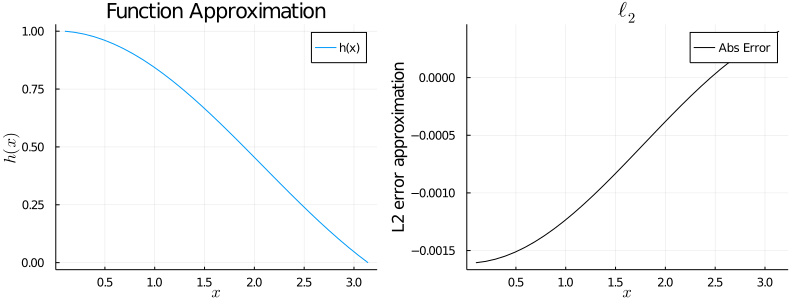

In [35]:
p1 = plot(xi_values, h_new, label="h(x)",
    ylabel=L"h(x)", xlabel=L"x", title="Function Approximation")
p2 = plot(xi_values, h.(xi_values) - h_new,
    label="Abs Error", c="black", title=L"\ell_2",
    xlabel=L"x", ylabel="L2 error approximation")

plot(p1, p2, layout=(1, 2), size=(800, 300))

## Question 5: Numerical Integration

We will compute the definite integral

$$
    I = \int_{-1}^{1}\frac{1}{1 + 25x^2} dx
$$

Using
1. The composite trapezium
2. The Hermite integration rule
3. The Clenshaw-Curtis quadrature rule

And compare their results to the exact result $I_\text{exact} = \frac{2}{5}\tan^{-1}(5)$

In [36]:
# The exact result of the integral
I_exact = 2atan(5) / 5

0.5493603067780064

In [37]:
# The function we wish to integrate
f(x) = 1 / (1 + 25x^2);

### a) Integration via the composite trapezium rule

In [38]:
function w_trapezium(n, N, Δx)
    """
    Compute the weights required for the
    trapezium rule
    
    n: int
        The current observed index
        (starting from 0)
    N: int
        The final observed index
        (starting from 0)
    Δx: float
        The assigned step-size
    """
    ind = n in [0, N] ? 1 : 0
    return Δx / (1 + ind)
end

function trapezium_rule(f, a, b, N)
    """
    Integrate from a to b using N + 1
    using equidistant points
    
    Parameters
    ----------
    f: function
        The function to integrate
    a: float
        The lower limit of the integration
    b: float
        The upper limit of the integration
    N: int
        Number of grid points - 1
    """
    Δx = (b - a) / N
    grid_points = a:Δx:b
    f_points = f.(grid_points);
    I = sum([fi * w_trapezium.(i - 1, N, Δx)
             for (i, fi) in enumerate(f_points)])
    return I
end

trapezium_rule (generic function with 1 method)

In [39]:
a, b = -1, 1
N = 63

I_trapezium = trapezium_rule(f, a, b, N)

0.5493478852994382

In [40]:
I_trapezium - I_exact

-1.2421478568169775e-5

### b) Integration via the Hermite integration rule

In [41]:
function hermite_rule(f, f_prime, a, b, N)
    """
    Integrate from a to b using N + 1
    using equidistant points using the hermite
    integration rule
    
    Parameters
    ----------
    f: function
        The function to integrate
    a: float
        The lower limit of the integration
    b: float
        The upper limit of the integration
    N: int
        Number of grid points - 1
    """
    Δx = (b - a) / N
    correct = Δx ^ 2 / 12 * (f_prime(a) - f_prime(b))
    I = trapezium_rule(f, a, b, N)
    I += correct
    return I
end

hermite_rule (generic function with 1 method)

In order to make use of the composite Hermite intergration rule, we need to work with the derivative of $f'(x)$ evaluated at $x=a$ and $x=b$. Note that

$$
f(x) = \frac{1}{1 + 25x^2}
$$

Implies

$$
\begin{aligned}
\frac{d}{dx} f(x) &= -(1 + 25x^2)^{-2} 50x\\
&= -\frac{50x}{(1 + 25x^2)^{2}}
\end{aligned}
$$

In [42]:
f_prime(x) = -50x / (1 + 25x^2)^2
a, b = -1, 1
N = 63

I_hermite = hermite_rule(f, f_prime, a, b, N)

0.5493603089992857

In [43]:
I_hermite - I_exact

2.2212792716302943e-9

### c) Integration via the Clenshaw-Curtis quadrature rule

In [44]:
function clenshaw_curtis_rule(f)
    """
    Integrate from -1 to 1 using N + 1
    using the Clenshaw-Curtis integration rule
    
    Parameters
    ----------
    f: function
        The function to integrate
    """
    theta_N = [n * pi / N for n in 0:N]
    x_N = -cos.(theta_N)
    f_N = f.(x_N)

    k = 1:N-1/2

    weights = 2 * cos.(2 .* k[new, :] .* theta_N[:, new]) ./ (4 * k[new, :] .^ 2 .- 1)
    weights = sum(weights, dims=2)
    weights = 2 / N * (1 .- weights)
    weights[[1, end]] .= 1 / N ^ 2
    
    return sum(weights .* f_N)

end

clenshaw_curtis_rule (generic function with 1 method)

In [45]:
I_clenshaw_curtis = clenshaw_curtis_rule(f)

0.5493901605182977

In [46]:
I_clenshaw_curtis - I_exact

2.9853740291296837e-5

## Question 6: Finite differences

In this section, we will make use of the finite differences' method.

We first recall that the Lagrange interpolation formula is given by

$$
    P_N(x) = \sum_{n=1}^N L_n(x) f(x_n)
$$

With

$$
    L_n(x) = \prod_{k\neq n}\frac{x - x_k}{x_n - x_k}
$$


This last equation implies that

$$
\frac{d}{dx} L_n(x) = \frac{\sum_{k\neq n} (x - x_k)}{\prod_{k\neq n} (x_n - x_k)}
$$



Suppose we have three points, then the lagrange interpolation formula becomes

$$
    P_3(x_n) = L_{n-1}(x_n) f(x_{n-1}) + L_{n}(x_n) f(x_{n}) + L_{n+1}(x_n) f(x_{n+1}) + O(\Delta x^3)
$$

We begin by showing the **2nd-order centred difference** formula given by

$$
f'(x_i) = \frac{f(x_{i+1}) - f(x_{i-1})}{2\Delta x} + O(\Delta x^2) \label{eq:fd2}\tag{1}\\
$$

Consider the set of three equdistant points $\{x_{n-1}, x_n, x_{n + 1}\} = \{x_n - \Delta x, x_n, x_n + \Delta x\}$, 

$$
\begin{aligned}
    \frac{d}{dx}L_{n}(x_n)
    &= \frac{(x_{n} - x_{n-1}) + (x_{n} - x_{n+1})}{(x_{n} - x_{n-1})(x_{n} - x_{n+1})}\\
    &= \frac{\Delta x + -\Delta x}{(\Delta x)(-\Delta x)}\\
    &= 0 
\end{aligned}
$$


$$
\begin{aligned}
    \frac{d}{dx}L_{n-1}(x_n)
    &= \frac{(x_{n} - x_{n}) + (x_{n} - x_{n+1})}{(x_{n-1} - x_{n})(x_{n-1} - x_{n+1})} \\
    &= \frac{0 + -\Delta x}{(\Delta x)(-2\Delta x)}\\
    &= \frac{-1}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{n+1}(x_n)
    &= \frac{(x_{n} - x_{n}) + (x_{n} - x_{n-1})}{(x_{n+1} - x_{n})(x_{n+1} - x_{n-1})}\\
    &= \frac{0 + \Delta x}{(\Delta x)(2\Delta x)}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$

Therefore

$$
\begin{aligned}
\frac{d}{dx}f(x_n) &= \frac{d}{dx}L_{n-1}(x_n)f(x_{n-1}) + \frac{d}{dx}L_{n}(x_n) f(x_n) + \frac{d}{dx}L_{n+1}(x_n) f(x_{n+1})\\
&= \frac{f(x_{n+1}) - f(x_{n-1})}{2\Delta x} + O(\Delta x^2)
\end{aligned}
$$

Next, to show the **left difference formula** given by

$$
    f'(x_0) = \frac{-3f(x_0) + 4 f(x_1) - f(x_2)}{2\Delta x} + O(\Delta x^2)
$$

Consider the set of equidistant points $\{x_0, x_1, x_2\} = \{x_0, x_0 + \Delta x,  x_0 + 2\Delta x\}$ and the values


$$
\begin{aligned}
    \frac{d}{dx}L_{0}(x_0)
    &= \frac{(x_{0} - x_{1}) + (x_{0} - x_{2})}{(x_{0} - x_{1})(x_{0} - x_{2})}\\
    &= \frac{-\Delta x -2\Delta x}{-\Delta x\cdot-2\Delta x}\\
    &= \frac{-3}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{1}(x_0)
    &= \frac{(x_{0} - x_{0}) + (x_{0} - x_{2})}{(x_{1} - x_{0})(x_{1} - x_{2})}\\
    &= \frac{0 - 2\Delta x}{\Delta x\cdot -\Delta x}\\
    &= \frac{4}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{2}(x_0)
    &= \frac{(x_{0} - x_{0}) + (x_{0} - x_{1})}{(x_{2} - x_{0})(x_{2} - x_{1})}\\
    &= \frac{0 - \Delta x}{2\Delta x\cdot\Delta x}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$

Implies,

$$
\begin{aligned}
\frac{d}{dx} f(x_0) &= \frac{d}{dx}L_{0}(0)f(x_{0}) + \frac{d}{dx}L_{1}(x_0) f(x_1) + \frac{d}{dx}L_{2}(x_0) f(x_{2})  + O(\Delta x^2)\\
&= \frac{-3f(x_0) + 4 f(x_1) - f(x_2)}{2\Delta x}  + O(\Delta x^2)
\end{aligned}
$$

Finally, we show the **right difference formula** given by

$$
f'(x_N) = \frac{f(x_{N-2}) - 4f(x_{N-1}) + 3 f(x_N)}{2\Delta x} + O(\Delta x^2)
$$

Consider the set of equidistant points $\{x_N, x_{N-1}, x_{N-2}\} = \{x_N, x_{N} - \Delta x, x_{N} - 2\Delta x\}$

and the values

$$
\begin{aligned}
    \frac{d}{dx}L_{N}(x_N)
    &= \frac{(x_{N} - x_{N-1}) + (x_{N} - x_{N-2})}{(x_{N} - x_{N-1})(x_{N} - x_{N-2})}\\
    &= \frac{\Delta x + 2\Delta x}{\Delta x\cdot 2\Delta x}\\
    &= \frac{3}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{N-1}(x_N)
    &= \frac{(x_{N} - x_{N}) + (x_{N} - x_{N-2})}{(x_{N-1} - x_{N})(x_{N-1} - x_{N-2})}\\
    &= \frac{0 - 2\Delta x}{-\Delta x\cdot -\Delta x}\\
    &= \frac{-4}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{N-2}(x_N)
    &= \frac{(x_{N} - x_{N}) + (x_{N} - x_{N-1})}{(x_{N-2} - x_{N})(x_{N-2} - x_{N-1})}\\
    &= \frac{0 + \Delta x}{2\Delta x\cdot \Delta x}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$


Implies

$$
\begin{aligned}
\frac{d}{dx} f(x_N) &= \frac{d}{dx}L_{N}(x_N)f(x_{N}) + \frac{d}{dx}L_{N-1}(x_N) f(x_{N-1}) + \frac{d}{dx}L_{N-2}(x_N) f(x_{N-2}) + O(\Delta x^2)\\
&= \frac{f(x_{N-2}) - 4f(x_{N-1}) + 3 f(x_N)}{2\Delta x} + O(\Delta x^2)
\end{aligned}
$$

### Finite differences

$$
    \frac{d}{dx}f(x) = \frac{f(x_{n+1}) - f(x_{n-1})}{2\Delta x} + O(\Delta x^2)
$$

In this section, we will define a function that uses the finite differences method to numerically evaluate the first derivative of the function

$$
    f(x) = \exp(-x^2)
$$

In [47]:
# Defining the target function and its -known- derivative
function f(x::Float64)
    return exp(-x ^ 2.0)
end

function df(x::Float64)
    return -2.0 * exp(-x ^ 2.0)x
end

df (generic function with 1 method)

In [48]:
function diffn(f0, f1, f2, Δx, n, N)
    """
    Evaluation of the derivative of a second-order polynomial
    via Lagrange interpolation as a function of its index
    """
    if n == 1
        df = (-3.0 * f0 + 4.0 * f1 - f2) / (2.0 * Δx)
    elseif n == N + 1
        df = (f0 - 4.0 * f1 + 3.0 * f2) / (2.0 * Δx)
    else
        df = (f2 - f0) / (2.0 * Δx)
    end 
    
    return df
end

function finite_diff(f_obs, Δx)
    """
    Implementatin of the finite differences method
    """
    n_obs = length(f_obs)
    f_prime = zeros(n_obs)
    
    for n in 1:n_obs
        if n >= n_obs - 1
            f0 = f_obs[n_obs - 2]
            f1 = f_obs[n_obs - 1]
            f2 = f_obs[n_obs]
        else
            f0 = f_obs[n]
            f1 = f_obs[n + 1]
            f2 = f_obs[n + 2]
        end
        
        df = diffn(f0, f1, f2, Δx, n, n_obs)
        f_prime[n] = df
    end
    
    return f_prime
end

finite_diff (generic function with 1 method)

To approximate the derivative of `f`, we will make use of 32 equally-spaced points over the interval $[-1, 1]$ as defined below.

In [49]:
N = 31
Δx = 2 / N
x_obs = -1:Δx:1
f_obs = f.(x_obs);

Next, we make use of our function `finite_diff` at the observed values and graph the error

$$
    \langle e\rangle = \frac{1}{N + 1}\sum_{n=1}^N |e_i|^2
$$

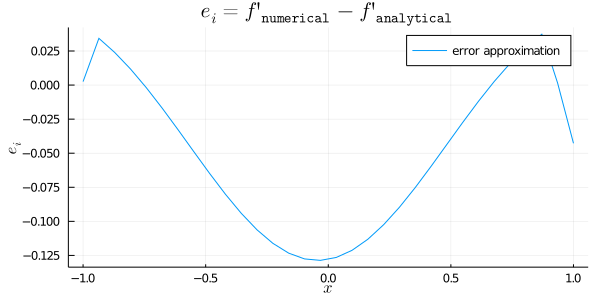

In [50]:
title = L"e_i = f'_\texttt{numerical} - f'_\texttt{analytical}"
df_approx = finite_diff(f_obs, Δx)
errs = df_approx - df.(x_obs)
p1 = plot(x_obs, errs,
    label="error approximation", title=title,
    xlabel=L"x", ylabel=L"e_i")

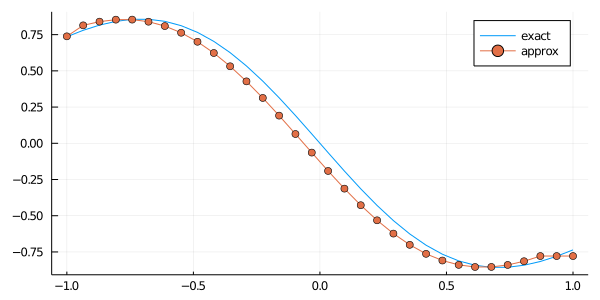

In [51]:
p2 = plot(x_obs, df.(x_obs), label="exact")
plot!(x_obs, df_approx, label="approx", marker=true)

We note that by increasing the number of points, the numerical method approaches the true derivative

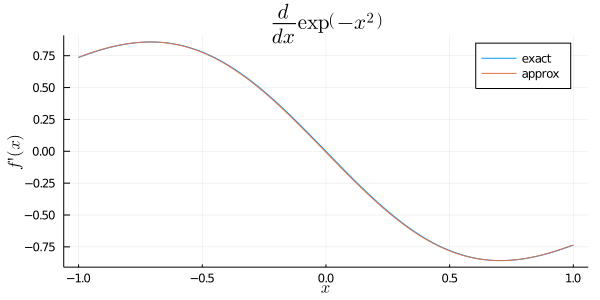

In [52]:
N = 520
Δx = 2 / N
x_obs = -1:Δx:1
f_obs = f.(x_obs);
df_approx = finite_diff(f_obs, Δx)

plot(x_obs, df.(x_obs), label="exact", xlabel=L"x", ylabel=L"f'(x)")
plot!(x_obs, df_approx, label="approx", title=L"\frac{d}{dx}\exp\left(-x^2\right)")

### Second order convergence

In [53]:
N_vals = 10:1:200
Δx_vals = 2 ./ N_vals

errors = zeros(length(N_vals))
for (n, N) in enumerate(N_vals)
    Δx = 2 / N
    x_obs = -1:Δx:1
    f_obs = f.(x_obs)
    df_approx = finite_diff(f_obs, Δx)
    err_n = df_approx - df.(x_obs)
    err_n = sum(abs.(err_n)) / (N + 1)
    errors[n] = err_n
end

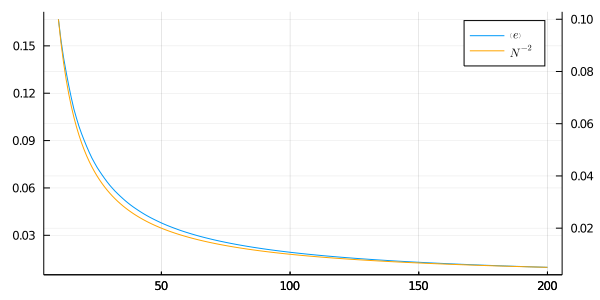

In [54]:
plot(N_vals, errors, label=L"\left\langle e \right\rangle")
plot!(N_vals, NaN .* N_vals,label=L"N^{-2}", c="orange")
plot!(twinx(), N_vals, 1 ./ N_vals, legend=false, c="orange")

In [55]:
i = 1:20:length(N_vals)
ei = (errors .* N_vals)[i]
Ni = N_vals[i]


function formatters(v, i, j)
    vi = j < 3 ? Int(v) : round(v, digits=3)
    return vi
end

data = [i Ni ei]
pretty_table(data, ["i", "N", "ei"], formatters=formatters)

┌─────┬─────┬───────┐
│   i │   N │    ei │
├─────┼─────┼───────┤
│   1 │  10 │ 1.669 │
│  21 │  30 │ 1.849 │
│  41 │  50 │ 1.892 │
│  61 │  70 │ 1.911 │
│  81 │  90 │ 1.922 │
│ 101 │ 110 │ 1.929 │
│ 121 │ 130 │ 1.933 │
│ 141 │ 150 │ 1.937 │
│ 161 │ 170 │  1.94 │
│ 181 │ 190 │ 1.942 │
└─────┴─────┴───────┘
